# Lab 4: Potential Pitfalls of Predict-Then-Act

ENGS 199.20  
2025-10-10

## Overview

Today we’re going to learn about the potential pitfalls of predicting
then acting for problems characterized by deep uncertainty. This lab
adapts the analysis from [Managing the risk of uncertain threshold
responses: comparison of robust, optimum, and precautionary
approaches](http://dx.doi.org/10.1111/j.1539-6924.2007.00940.x) by
Lempert and Collins, 2007.

Today’s objectives:

1.  Calculate the regret of a strategy in individual states and across
    states
2.  Calculate a strategy’s satisficing robustness
3.  Visualize different robustness for various metrics and strategies in
    insightful ways
4.  Demonstrate your conceptual understanding of the two robustness
    criteria from the study
5.  (Optional) Apply the workflow to your project data

## Lab Workflow

### Repository Setup

You can call the repository `rdm_lab/`.

If you need a reminder on how to set up your project directory and
create a GitHub repository, check the workflow and directory structure
from lab 2.

You can directly export these lab instructions as a `.ipynb` file (look
at the top right of the page). Place this file in the `noteboks/`
subdirectory.

### Environment Setup

For today’s lab, you will need to create an environment that has all the
packages from lab 2, plus `scipy`.

Be sure to include instructions in your `README.md` about how others can
prepare the computational environment to run your notebook.

### Our Analysis

Make sure your environment is set up and active to run the code cells
below.

#### Lake Problem Overview

Quoting from Lempert and Collins (2007): “Imagine a small village
perched on the shores of a pristine lake. Many of the town’s citizens
want economic development, but development will increase the pollution
flowing into the lake. The citizens know that lakes such as theirs can
exhibit a threshold behavior where a small pollution increase past some
level may cause a clear lake to turn suddenly and sometimes irreversibly
cloudy. The citizens seek a development plan that preserves the clarity
of their lake, cognizant of their widely divergent values regarding
environmental quality and growth, as well their divergent opinions about
the level where the pollution threshold for their lake might lie. The
town’s citizens also know that once permits are issued, buildings built,
and pollution begins to flow it may become difficult to reverse course.
Nonetheless, they must decide how much pollution they should allow to
best balance their economic and environmental goals.”

<figure>
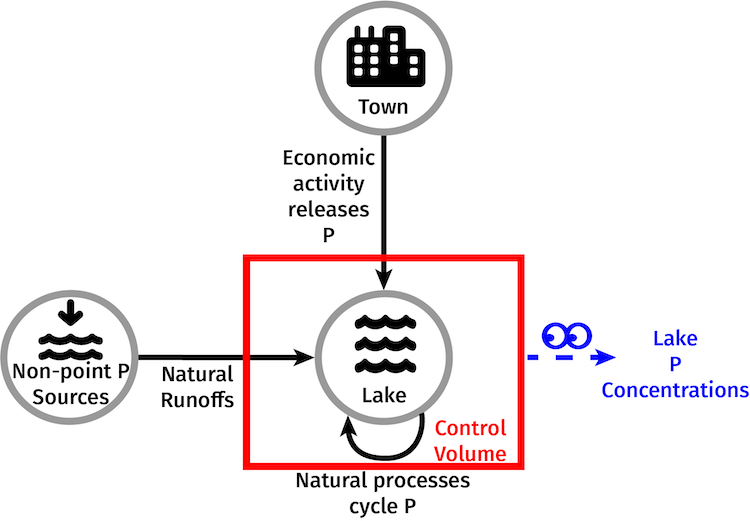
<figcaption aria-hidden="true">Shallow Lake Model diagram from <a
href="https://envsys.viveks.me/fall2025/slides/lecture03-2-equilibria-bifurcations.html#/shallow-lake-model-1">Vivek
Srikrishnan’s Fall 2025 Environmental Systems Analysis
Slides</a></figcaption>
</figure>

The lake naturally loses and gains phosphorus (P). The lake can exist in
one of two states. The desirable state, called an oligotrophic state,
exists with low nutrient inputs, low to moderate levels of plant
production, and relatively clear water. The undesirable state, called an
eutrophic state, exists with high nutrient levels, high levels of plant
production, low biodiversity, and murky water. The introduction of
economic activity to the lake increases the risk of eutrophication.

Lempert and Collins (2007) represent the lake problem with the following
equation (with a little clarification from revisiting [Peterson et al.,
(2003)](https://doi.org/10.1890/0012-9658(2003)084%5B1403:UATMOM%5D2.0.CO;2)):
$$
X_{t+1} = 
\begin{cases}
    BX_t + b_t + L_t & \text{if } X_t < X^{\text{crit}} \\
    BX_t + r + b_t + L_t & \text{if } X_t \geq X^{\text{crit}}
\end{cases}
$$

where $X_{t}$ is the P concentration at time $t$, $B$ is the proportion
of P retained in the lake each year, $b_{t} = (\bar{b}, \omega)$ is the
natural pollution flow into the lake assumed to follow a normal
distribution with mean $\bar{b}$ and standard deviation $\omega$,
$L_{t}$ is the anthropogenic pollution flow, and $r$ is the amount of P
recycled and maintained in the lake. $X^{\text{crit}}$ is the critical P
concentration at which P recycling begins.

The two alternating equilibrium values are found by letting
$X_{t+1} = X{t}$:

$$
\begin{array}{l}
    X_{1*} = \frac{\bar{b} + L}{1 - B} & \text{if } X_{1*} < X^{\text{crit}} \\
    X_{2*} = \frac{r + \bar{b} + L}{1 - B} & \text{if } X_{2*} \geq X^{\text{crit}}
\end{array}
$$

If $X_{1*} < X^{\text{crit}}$ an oligotrophic equilibrium exists, and if
$X_{2*} \geq X^{\text{crit}}$ a eutrophic equilibrium also exists.
Because the equilibrium value of $X$ depends upon the P loading, changes
in P loading can cause equilibrium point to appear or disappear. Figure
2 from Peterson et al., (2003), shown below, illustrates how changes in
P loading can irreversibly alter the lake system’s outcomes:

<figure>
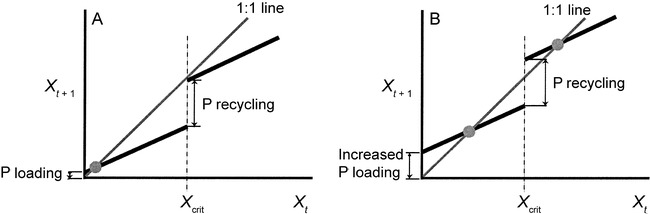
<figcaption aria-hidden="true">An illustration of the P dynamics model.
In example (A), low P loading results in a single stable oligotrophic
equilibrium. In (B), at a higher P loading the same lake has two stable
equilibrium values—one oligotrophic (the lower point) and one eutrophic
(the higher point)</figcaption>
</figure>

Lempert and Collins (2007) assume that the citizens of the town gain
utility by adding pollutants to the lake, but suffer a loss of utility
if the lake becomes eutrophic. They represent the utility function as:

$$
U'_{t} = 
\begin{cases}
    \alpha L_{t} - \phi (L_{t} - L_{t-1}) & \text{if } X_t < X^{\text{crit}} \\
    \alpha L_{t} - \beta - \phi (L_{t} - L_{t-1}) & \text{if } X_t \geq X^{\text{crit}}
\end{cases}
$$

where $\alpha$ and $\beta$ are constants. $\beta >> \alpha L_{t}$,
representing that the loss of utility in the eutrophic state (e.g.,
recreational and aesthetic utility) is large compared to the utility
gained from pollution. The citizens also may suffer economic losses,
such as costs of retrofitting infrastructure with pollution control
equipment or underutilization of capital stock, if they are forced to
decrease emissions below their previously allowed level. These costs are
small compared to those of the eutrophic state, given by:

$$
\phi (L_{t} - L_{t-1}) = 
\begin{cases}
    0 & \text{if } L_{t} \geq L_{t-1} \\
    \varphi & \text{if } L_{t} < L_{t-1}
\end{cases}
$$

where $\varphi$ is a constant and
$\varphi << \frac{\beta}{L_{t-1} - L_{t}}$.

The town’s decision problem is to choose a pollution series,
$\mathbf{L_t}$,

Lempert and Collins propose a policy rule that has three decision
variables: the initial level of pollution, $L_{0}$, the max amount of
pollution per time period, $\Delta L$, and a safety margin, $S$. This
decision strategy takes the following form:

$$
L_{t+1} = 
\begin{cases}
    Max\{0, Min[L_{t} + \Delta L, L^{\text{target}}_{t}]\} & \text{for } t \geq 1 \\
    L_{0} & \text{for } t = 0
\end{cases}
$$

where the target emission level at time $t$ is given by:

$$
L^{\text{target}} = 
\begin{cases}
    (1 - B) \langle X^{\text{crit}}_{t} \rangle - \bar{b} - S\omega  & \text{if } X_{t} < X^{\text{crit}} \\
    \langle X^{\text{crit}}_{t} \rangle - BX_{t} - r - \bar{b} - S\omega & \text{if } X_{t} \geq X^{\text{crit}}
\end{cases}
$$

and $\langle X^{\text{crit}}_{t} \rangle$ is the town’s estimated
critical threshold at the current time period. Please refer to the paper
for the formulation.

Under an expected utility maximization framework for decision-making,
the town aims to maximize the present value of utility:
$PV(U) = \sum_{t} \frac{U_{t}}{(1 + d)^{t}}$, where $d$ is the citizens’
discount rate. Given the available information to estimate
$\langle X^{\text{crit}}_{t} \rangle$, the town can find the optimal
values for their decision variables. As we’ll see later in the lab (and
as you already know from reading the paper), whether this is the *right*
decision to make depends on how much you believe the information you
have to estimate $\langle X^{\text{crit}}_{t} \rangle$.

The basecase values of model parameters are as follows:

| Parameter | Value |
|:--:|:--:|
| Retained phosphorous (B) | .2 |
| Mean of natural emissions ($\hat{b}$) | .1 |
| Initial P concentration ($X_{0}$) | $\hat{b}$/(1 - B) = .125 |
| Std of natural emissions $\omega$ | .04 |
| Recycling rate (r) | .25 |
| Std of measured $X^{\text{crit}}$ ($\gamma$) | .05 |
| Distance from $X^{\text{crit}}$ required for learning ($\lambda$) | .1 |
| Noise exponent (q) | 2 |
| Initial estimate of observed $X^{\text{crit}}$ variance | .02 |
| Discount rate (d) | .03 |
| Utility from pollution ($\alpha$) | 1 |
| Eutrophic cost ($\beta$) | 10 |
| Emissions reduction cost ($\varphi$) | 1 |

*Note*: While the table in the text has $\varphi$ as 10, the text
clearly states that this emissions reduction cost is much smaller than
the eutrophic cost so it is a typo. I’m guessing it’s supposed to be 1
(similarly, the initial estimate of observed $X^{\text{crit}}$ variance
is a typo in the paper’s table).

### Decision-making under uncertainty

**Note** that I was not able to reproduce the results from Lempert and
Collins completely. There are a few typos (e.g., see their Table on
parameter values and the reported initial estiamte of observed
$X_{\text{crit}}$ and the one I was able to update based on other text
in the paper). There are a few decisions and implementation choices I
can’t back out without more guidance, but I was able to reproduce the
most relevant behavior of the inflows and policies. I made a few updates
relative to the policy rules as written in the manuscript:

1.  I estimate the new best guess for $X_{\text{crit}}$ based on the
    current best guess for variance. The notation as currently written
    suggests we calculate the new variance before updating our mean
    estimate.
2.  I limit updates on standard deviation of $X_{\text{crit}}$ to double
    our intial guess. If we don’t do this, there is too much noise in
    early draws and we can’t identify when our initial guess is lower
    than $X^{\text{true}}_{\text{crit}}$. I think this biases our
    representation a bit more towards trusting our priors than the
    Lempert and Collins paper, but I can’t otherwise figure out how to
    get the same learning behavior as them for Strategy A when
    $X^{\text{true}}_{\text{crit}}$ = .9.

Anyone who wants to review the paper and code and reconcile any major
differences with explanations or code updates is more than welcome!

Because the code below does reproduce key behavior of the inflows and
policies, all of the lessons about robustness are the same and that’s
the key point of this lab.

Ok! Moving on…

Adapting the narrative of Lempert and Collins slightly, suppose the town
reviewed scientific evidence of nearby lakes and concludes that
$X_{\text{crit}}$ lies between .3 and .9. The current best evidence
suggets $X_{\text{crit}} \sim N(.8, .138)$.

If the town has 100% confidence in this belief, the optimal strategy
(called Strategy A) has: $L_{0} = .31$, $\Delta L = .027$ $S = 2.8$

Assume that the true value of $X_{\text{crit}}$ is .9. What does the
pollution concentration of the lake look like over 100 years? What about
if the true value is .3?

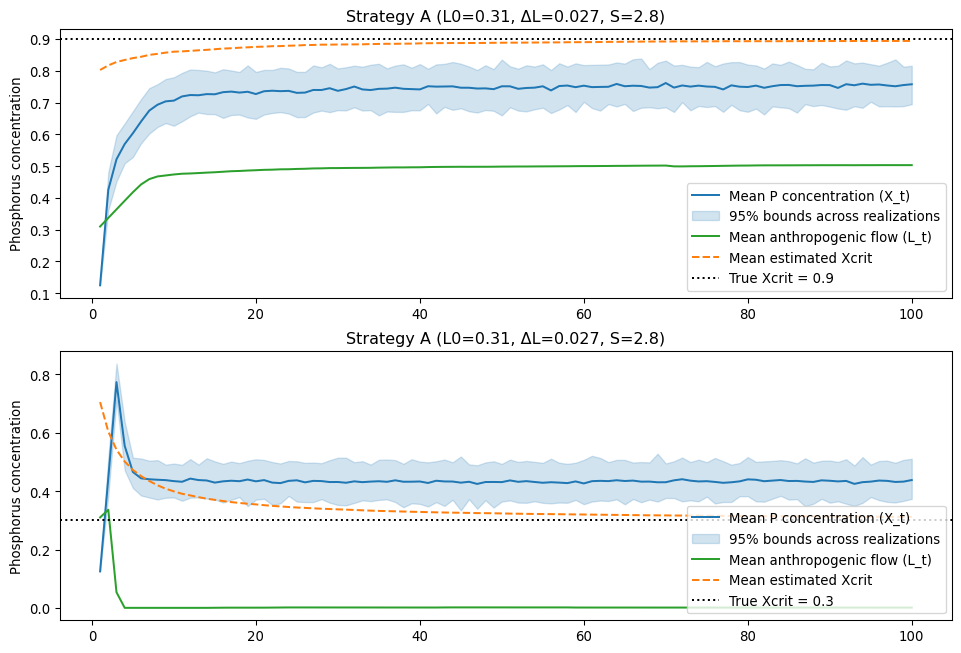

In [1]:
import math
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# Parameters (Table I / paper)
# ------------------------
B = 0.20           # retained phosphorus
b_bar = 0.10       # mean natural emissions
omega = 0.04       # std dev natural emissions
r = 0.25           # recycling jump when X >= Xcrit
gamma_obs = 0.05   # baseline observation noise std
lambda_learn = 0.10
q_noise = 2.0
initial_var = 0.02
alpha = 1.0
beta = 10.0
phi = 1.0 # table says 10 but the text says << beta
discount_rate = 0.03

# Strategy A (given)
strategy_A = {"L0": 0.31, "dL": 0.027, "S": 2.8}

# Simulation controls
T = 100                # years
Nsim = 100             # ensemble size for mean / quantiles (set e.g., 100 for demo)
SEED = 42
rng_global = np.random.default_rng(SEED)

# Initial estimate used by the town
initial_est_mean = 0.787
initial_est_var = initial_var
est_lower = .3
est_upper = .9

# ------------------------
# Helper functions implementing paper's learning and policy rules
# ------------------------
def gamma_t_func(Xt, Xcrit_true, gamma=gamma_obs, lam=lambda_learn, q=q_noise):
    """Equation (6): observation noise depends on proximity to threshold."""
    if Xt >= Xcrit_true:
        return float(gamma)
    exponent = ((Xcrit_true - Xt) / lam) ** q
    return min(gamma * math.exp(exponent), .1)         

def kalman_update(mean_prev, var_prev, Zt, gamma_t):
    """Scalar Kalman-like update (Equation (5))"""
    K = var_prev / (var_prev + gamma_t)
    mean_new = mean_prev + K * (Zt - mean_prev)
    var_new = (var_prev * gamma_t) / (var_prev + gamma_t)
    return mean_new, var_new

def target_emission_level(estimated_Xcrit, Xt, Xcrit_true, S):
    """Equation (8) for L_target"""
    if Xt < Xcrit_true:
        target = (1.0 - B) * estimated_Xcrit - b_bar - S * omega
    else:
        target = estimated_Xcrit - B * Xt - r - b_bar - S * omega
    return max(0.0, target)

def next_L(Lt, L_arg, dL):
    """Equation (7) update for L"""
    return max(0.0, min(Lt + dL, L_arg))

def simulate_one_run_with_learning(Xcrit_true,
                                   policy,
                                   T=100,
                                   rng=None,
                                   est_mean_init=initial_est_mean, est_var_init=initial_est_var):
    """
    Simulate one stochastic run with Kalman learning and the adaptive policy (L0, dL, S).
    Returns time series dict with keys: X, L, est (estimated Xcrit), U (period utilities)
    """
    if rng is None:
        rng = np.random.default_rng()
    L0 = float(policy["L0"]) 
    dL = float(policy["dL"])
    S = float(policy["S"])
    X = np.empty(T)
    L = np.empty(T)
    Z = np.empty(T)
    est = np.empty(T)
    U = np.empty(T)
    Xt = b_bar / (1.0 - B)  # initial concentration per paper
    L_prev = L0
    L_curr = L0
    est_mean = est_mean_init
    est_var = est_var_init

    for t in range(T):
        # natural inflow
        bt = rng.normal(b_bar, omega)
        # update concentration (Eqn 1)
        if Xt >= Xcrit_true:
            Xt_next = B * Xt + r + bt + L_curr
        else:
            Xt_next = B * Xt + bt + L_curr
        # observation for learning: Zt ~ N(Xcrit_true, gamma_t)
        gamma_t = gamma_t_func(Xt, Xcrit_true)
        Zt = rng.normal(loc=Xcrit_true, scale=gamma_t)
        # Kalman update
        est_mean, est_var = kalman_update(est_mean, est_var, Zt, gamma_t)
        # utility for this period (using current Xt and current emissions L_curr)
        reduction_cost = phi * max(0.0, L_prev - L_curr)
        eutrophic_penalty = beta if Xt >= Xcrit_true else 0.0
        U[t] = alpha * L_curr - reduction_cost - eutrophic_penalty
        # record
        X[t] = Xt
        L[t] = L_curr
        est[t] = est_mean
        # compute target and update emissions
        L_targ = target_emission_level(est_mean, Xt, Xcrit_true, S)
        L_next = next_L(L_curr, L_targ, dL)
        L_prev = L_curr
        L_curr = L_next
        Xt = Xt_next

    return {"X": X, "L": L, "est": est, "U": U}

# ------------------------
# Run simulation 
# ------------------------
all_X = np.zeros((Nsim, T))
all_L = np.zeros((Nsim, T))
all_est = np.zeros((Nsim, T))
all_U = np.zeros((Nsim, T))

all_X2 = np.zeros((Nsim, T))
all_L2 = np.zeros((Nsim, T))
all_est2 = np.zeros((Nsim, T))
all_U2 = np.zeros((Nsim, T))

# True Xcrits for this illustration
xcrit_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_x = len(xcrit_list)

# pre-allocate arrays: shape (n_x, Nsim, T)
all_X = np.zeros((n_x, Nsim, T))
all_L = np.zeros((n_x, Nsim, T))
all_est = np.zeros((n_x, Nsim, T))
all_U = np.zeros((n_x, Nsim, T))

# Pre-generate natural inflows bt_samples for each Monte Carlo run (CRN across Xcrit)
rng_global = np.random.default_rng(SEED)
bt_samples = rng_global.normal(loc=b_bar, scale=omega, size=(Nsim, T))

# Run ensemble
for i in range(Nsim):
    # create per-run rng for observation draws (do not re-seed inside loop)
    rng_i = np.random.default_rng(SEED + 1000 + i)
    for j, xcrit in enumerate(xcrit_list):
        out = simulate_one_run_with_learning(Xcrit_true=xcrit,
                                             policy=strategy_A,
                                             T=T,
                                             rng=rng_i,
                                             est_mean_init=initial_est_mean,
                                             est_var_init=initial_est_var)
        all_X[j, i, :] = out["X"]
        all_L[j, i, :] = out["L"]
        all_est[j, i, :] = out["est"]
        all_U[j, i, :] = out["U"]

# ------------------------
# Plot results: mean concentration, emissions, and estimated Xcrit
# ------------------------
years = np.arange(1, T+1)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Top: concentration and estimated threshold
ax[0].plot(years, all_X[-1].mean(axis=0), color="C0", label="Mean P concentration (X_t)")
ax[0].fill_between(years,
                   np.percentile(all_X[-1], 5, axis=0),
                   np.percentile(all_X[-1], 95, axis=0),
                   alpha=.2,
                   color="C0", label="95% bounds across realizations")
ax[0].plot(years, all_L[-1].mean(axis=0), color="C2", label="Mean anthropogenic flow (L_t)")
ax[0].plot(years, all_est[-1].mean(axis=0), color="C1", linestyle="--", label="Mean estimated Xcrit")
ax[0].axhline(xcrit_list[-1], color="k", linestyle=":", label=f"True Xcrit = {xcrit_list[-1]}")
ax[0].set_ylabel("Phosphorus concentration")
ax[0].set_title("Strategy A (L0=0.31, ΔL=0.027, S=2.8)")
ax[0].legend()

ax[1].plot(years, all_X[0].mean(axis=0), color="C0", label="Mean P concentration (X_t)")
ax[1].fill_between(years,
                   np.percentile(all_X[0], 5, axis=0),
                   np.percentile(all_X[0], 95, axis=0),
                   alpha=.2,
                   color="C0", label="95% bounds across realizations")
ax[1].plot(years, all_L[0].mean(axis=0), color="C2", label="Mean anthropogenic flow (L_t)")
ax[1].plot(years, all_est[0].mean(axis=0), color="C1", linestyle="--", label="Mean estimated Xcrit")
ax[1].axhline(xcrit_list[0], color="k", linestyle=":", label=f"True Xcrit = {xcrit_list[0]}")
ax[1].set_ylabel("Phosphorus concentration")
ax[1].set_title("Strategy A (L0=0.31, ΔL=0.027, S=2.8)")
ax[1].legend(loc='lower right')


When the neighboring lakes’ statistics are represenative of the town’s
lake (top panel, true Xcrit = 0.9), Strategy A lets emissions ramp up
and stabilizes at a moderate level that keeps the mean phosphorus
concentration under the town’s safety buffer. When the assessment is
badly wrong (bottom panel, true Xcrit = 0.3), the initial policy
overcommits — the emissions (and then concentration) rise, the town’s
estimate of $X_{\text{crit}}$ is revised downward as observations
arrive, and emissions are sharply cut only after the system has already
been driven into the eutrophic equilibrium. This illustrates how a
predict‑then‑act rule that trusts a single prior can be fragile under
deep uncertainty.

How much would the town regret going with Strategy A if
$X^{\text{true}}_{\text{crit}}$ = .3?

To estimate this, we are going to consider the town’s uncertainty about
their estimate of the value of $X_{\text{crit}}$ as well as epistemic
uncertainty about whether this is the *correct* distribution to
characterize $X_{\text{crit}}$.

Recall from lecture that the regret of action *a* in state *x* is:

$R_{a}(x) = Max_{a'}[PV(U_{a'}(x))] - PV(U_{a}(x))$,

the difference between the present value expected utility of the
*optimal* action in a considered state of the world and the *considered*
action’s present value expected utility in that state of the world.

Considering the probability distribution $p_{i}(x)$ over possible states
of the world, the expected regret of action *a* on distribution *i* is:

$$
\bar{R}_{a, i} = \int_{x} R_{a}(x)p_{i}(x)dx
$$

I use actions, *a*, as opposed to strategies in this formulation because
it is consistent with the original derivation in [Savage
(1951)](http://dx.doi.org/10.1080/01621459.1951.10500768). Otherwise,
the notation is consistent with the formulation in Lempert and Collins.
*x* refers to the possible values for $X_{\text{crit}}$ and *i* refers
to a specific prior distribution for $X_{\text{crit}}$.

For different values of $X_{\text{crit}}$, we can estimate the town’s
expected regret for placing all of their trust in the commissioned
science assessment. Lempert and Collins provide several other
strategies, B-G. For different values of $X_{\text{crit}}$, we can
calculate which of the strategies A-G is optimal and then calculate the
expected regret of choosing Strategy A based on the town’s prior
distribution for A. Lempert and Collins presumably identify the optimal
strategy for each $X_{\text{crit}}$ and calculate regret based on that,
but we are just going to use the strategies provided to simplify things.

We’ll start with the example of $X_{\text{crit}}$ = .3, which
corresponds to the bottom panel of the figure we generated above. At
$X_{\text{crit}}$ = .3, Strategy G is optimal out of the strategies
under consideration. Lempert and Collins don’t report the decision
variables for this strategy, but we can get a very similar strategy to G
by looking at Figure 6. It looks like $L_{0} = 0.01$, $\Delta L = 0.01$
and $S = 5.8$.

We’ll build up slowly to expected regret over a prior distribution by
first calculating the regret of Strategy A in the scenario where
$X_{\text{crit}}$ = 0.3. We need to calculate:

$R_{A}(0.3) = PV(U_{G}(0.3)) - PV(U_{A}(0.3))$

We’ll calculate the expected present value of utility of each strategy
when $X_{\text{crit}}$ = .3 and then the difference.

In [2]:
# Strategy G (guessed from Fig. 6)
strategy_G = {"L0": 0.01, "dL": 0.01, "S": 5.8}

# Create the utility array for strategy G
strat_g_U = np.zeros((n_x, Nsim, T))

# Run ensemble for Strategy G
for i in range(Nsim):
    # create per-run rng for observation draws (do not re-seed inside loop)
    rng_i = np.random.default_rng(SEED + 1000 + i)
    for j, xcrit in enumerate(xcrit_list):
        out = simulate_one_run_with_learning(Xcrit_true=xcrit,
                                             policy=strategy_G,
                                             T=T,
                                             rng=rng_i,
                                             est_mean_init=initial_est_mean,
                                             est_var_init=initial_est_var)
        strat_g_U[j, i, :] = out["U"]

# Compute present value of utility.
# Discount factors (length T)
t = np.arange(T)
discount_factors = 1.0 / ((1.0 + discount_rate) ** t)

pv_A_samples = np.sum(all_U[0, :, :] * discount_factors, axis=1) 
pv_G_samples = np.sum(strat_g_U[0, :, :] * discount_factors, axis=1)

# Calculate expected values and report both and difference
mean_pv_A = pv_A_samples.mean()
mean_pv_G = pv_G_samples.mean()

g_best_regret = mean_pv_G - mean_pv_A

print("Strategy A: mean PV = {:.2f}".format(mean_pv_A))
print("Strategy G: mean PV = {:.2f}".format(mean_pv_G))
print(" Regret = {:.2f}".format(g_best_regret))

Strategy A: mean PV = -310.81
Strategy G: mean PV = -17.38
 Regret = 293.43

And we can do the same for when $X^{\text{crit}}$ = .9 but this time we
treat Strategy A as the optimal policy.

In [3]:
# Compute present value of utility.
# Discount factors (length T)
t = np.arange(T)
discount_factors = 1.0 / ((1.0 + discount_rate) ** t)

pv_A_samples = np.sum(all_U[-1, :, :] * discount_factors, axis=1) 
pv_G_samples = np.sum(strat_g_U[-1, :, :] * discount_factors, axis=1)

# Calculate expected values and report both and difference
mean_pv_A = pv_A_samples.mean()
mean_pv_G = pv_G_samples.mean()

a_best_regret = mean_pv_A - mean_pv_G

print("Strategy A: mean PV = {:.2f}".format(mean_pv_A))
print("Strategy G: mean PV = {:.2f}".format(mean_pv_G))
print(" Regret = {:.2f}".format(a_best_regret))

Strategy A: mean PV = 15.24
Strategy G: mean PV = 7.27
 Regret = 7.98

#### Criterion 1: trading-off optimality for less sensitivity to unverifiable assumptions

How do we reconcile the differences in present value expected utility
and expected regret? Lempert and Collins define a robust strategy as one
that will have a smaller value of the weighted average of the best and
worst case regrets compared to the strategy that optimizes expected
utility, which we can represent as:

$$
V_{s} = z*\bar{R}_{s, \text{best}} + (1-z)*\bar{R}_{s, \text{worst}}
$$

where $0 \leq z \leq 1$ and represents our belief in
$p_{\text{best}(x)}$.

When $z$ = 1, there is only one probability distribution under
consideration - the town’s best guess. In this case, the equation above
preserves the ordering of strategies produced by an expected utility
calculation. When $z$ = 0, the criterion is equivalent to avoiding
worst-case utility. When $z$ is in between, it is possible to identify
the strategy that minimizes expected regret as a function of a
decisionmaker’s odds that the initial probability distribution is
correct (Fig. 7 in the paper). The odds are $\frac{z}{(1-z)}$.

How confident does the town have to be in the scientific assessment to
stick with Strategy A? To do this, we’ll calculate $V_{s}$ for
strategies A and G over a wide range of values for $z$. Since we are
only considering strategies A and G:

$\bar{R}_{A, \text{best}}$ is 0, $\bar{R}_{A, \text{worst}}$ is the
regret we calculated when $X_{crit}$ = 0.3, $\bar{R}_{G, \text{best}}$
is the regret we calculated when $X_{crit}$ = 0.9, and
$\bar{R}_{G, \text{worst}}$ is 0.

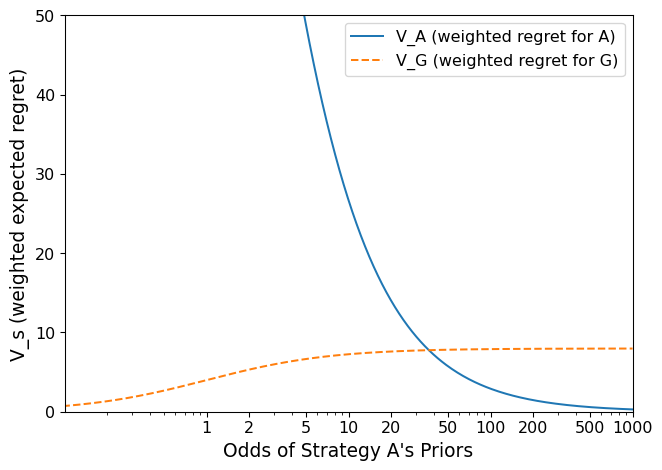

In [4]:
# Calculated V_s
def weighted_regret(z, best_regret, worst_regret):
    return z*(best_regret) + (1-z)*(worst_regret)

# Odds from 0.01 to 100
# Construct odds grid (log-spaced) and convert to z = odds/(1+odds)
odds = np.logspace(-2, 3, 500)
z_list = odds / (1.0 + odds)

# Calculate V_A and V_G over odds
V_A = z_list * 0 + (1 - z_list) * g_best_regret
V_G = z_list * a_best_regret + (1 - z_list) * 0

# Plot odds against weighted regret
fig, ax = plt.subplots()
ax.plot(odds, V_A, label='V_A (weighted regret for A)', linestyle='-')
ax.plot(odds, V_G, label='V_G (weighted regret for G)', linestyle='--')

ax.set_ylabel("V_s (weighted expected regret)", size=14)

ax.set_xscale('log')
# integer ticks to show (only those within the odds range will be used)
integer_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
# Choose x limits: show more of odds > 10 — e.g., start at 0.1 to include small odds too
ax.set_xlim(0.1, 1000)
# Keep only ticks that fall inside the x limits
ticks_in_range = [t for t in integer_ticks if (t >= ax.get_xlim()[0] and t <= ax.get_xlim()[1])]
ax.set_xticks(ticks_in_range)
# Label ticks as integers (no decimals)
ax.set_xticklabels([str(int(t)) for t in ticks_in_range])
ax.set_xlabel("Odds of Strategy A's Priors", size=14)

ax.set_ylim([0, 50])

ax.tick_params(labelsize=12)

ax.legend(fontsize='large')
fig.tight_layout()

Based on this figure and fig. 7 in the paper, we can make a few
observations about robust decision-making with this criterion. First,
because of how poorly strategy A performs under low $X^{true}_{crit}$,
the town should be very confident in the scientific assessment to go
with strategy A. Second, having more strategy options (fig. 7 in the
paper) can help decisionmakers make more robust decisions under a wide
range of beliefs.

#### Criterion 2: performing well over a wide range of plausible futures

We’ll now shift our attention to a second robustness criterion:
satisficing over a wide range of futures. While decisionmakers may want
to identify satisficing strategies over multiple objectives, Lempert and
Collins use regret for this criterion. This translates to finding a
strategy that has low regret for many values of $X^{true}_{crit}$. In
the paper, they define arbitrary cutoffs for what constitutes “good
enough” regret. In practice, analysts and decisionmakers often iterate
on defining a satisficing threshold based on visualizations about
strategy performance over a wide range of futures and refined sets of
strategies.

We’re going to consider both the net present value of expected utility
and regret for strategies A and G.

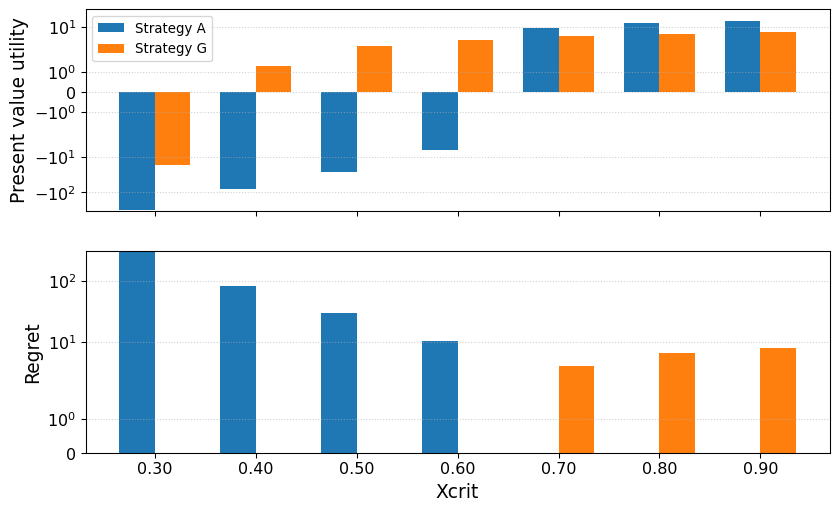

In [5]:
# Helpful for getting the pv for multiple xcrit
def compute_pvs_from_U(U_array, discount_rate):
    U = np.asarray(U_array)
    t = np.arange(U.shape[2])
    discount_factors = 1.0 / ((1.0 + discount_rate) ** t)
    pv = (U * discount_factors).sum(axis=2) 
    return pv

pv_A_samples = compute_pvs_from_U(all_U, discount_rate)     
pv_G_samples = compute_pvs_from_U(strat_g_U, discount_rate)  

# Mean present value over each xcrit
# Same index as all_U and strat_g_U
mean_pv_A = pv_A_samples.mean(axis=1)  
mean_pv_G = pv_G_samples.mean(axis=1) 

# Calculate regret
# Two strategies under consideration, so regret is
# 0 when one of the strategies is better for a xcrit value
pv_best_by_x = np.maximum(mean_pv_A, mean_pv_G) 
regret_A = pv_best_by_x - mean_pv_A
regret_G = pv_best_by_x - mean_pv_G

# Plot regret over critical x values in one panel
# Plot present value expected utility in the other
# x values (e.g., xcrit_list)
x = np.array(xcrit_list)
n_x = len(x)

# bar width and positions
width = 0.35
xpos = np.arange(n_x)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,6))

# Top: expected PV bars
ax0 = ax[0]
ax0.bar(xpos - width/2, mean_pv_A, width=width, color='C0', label='Strategy A')
ax0.bar(xpos + width/2, mean_pv_G, width=width, color='C1', label='Strategy G')
ax0.set_ylabel('Present value utility', size=14)
ax0.legend()
ax0.grid(axis='y', linestyle=':', alpha=0.6)

# Bottom: regret bars
ax1 = ax[1]
ax1.bar(xpos - width/2, regret_A, width=width, color='C0')
ax1.bar(xpos + width/2, regret_G, width=width, color='C1')
ax1.set_ylabel('Regret', size=14)
ax1.grid(axis='y', linestyle=':', alpha=0.6)

# x ticks and labels
ax1.set_xticks(xpos)
ax1.set_xticklabels([f"{val:.2f}" for val in x])
ax1.set_xlabel('Xcrit', size=14)

ax[0].set_yscale('symlog')
ax[1].set_yscale('symlog')

ax0.tick_params(labelsize=12)
ax1.tick_params(labelsize=12)

This kind of visualization helps put into context the relative
performance of the strategies for different scenarios of $X_{crit}$. For
example, Lempert and Collins suggest that regret \<= 12 is acceptable.
According to our calculations, unacceptable regret only becomes an issue
if the true $X_{crit}$ is less than .6. From a satisficing perspective,
if we wanted to ensure acceptable regret, we would prefer Strategy G
because it robustly achieves that goal. We could also consider an
alternative threshold, such as positive utility. Strategy G would be
more robust than strategy A because it has positive utility over more
scenarios of $X_{crit}$. Note that the satisficing approach does not
account for beliefs about the probability of different values for
$X_{crit}$. This may not be an appropriate assumption for all
situations, but it can still be helpful to represent robustness in
multiple ways.

### Wrapping up lab

There is no separate lab report this week. The project progress report
will ask you to think hard about this lab, but I would prefer you spend
your time and effort on your project than this toy example.

You are free to experiment with the code from this lab, or adapt any of
the code to expand the analysis or test your understanding. I am happy
to take a look and provide feedback or talk through challenging
concepts.